We'll first try with the simplest possible approach based on char-RNN that read all the excerpt and predicts in output the target complexity.

In [ ]:
!pip install torchtext

In [ ]:
import numpy as np
import torch
import random
import os
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import string
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence
from torchtext.vocab import GloVe

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is used")

# seed everything
seed = 1
random.seed(seed)
os.environ['PYTHONASSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
#os.environ['WANDB_CONSOLE'] = 'off'

cuda is used


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the data
# Internal datasets
training = pd.read_csv('/content/drive/MyDrive/Unipi/HLT/HLT-Project/internal_train.csv').to_numpy()
test = pd.read_csv('/content/drive/MyDrive/Unipi/HLT/HLT-Project/internal_test.csv').to_numpy()
# Real datasets (Keep only these ones for kaggle (delete test))
blind_test = pd.read_csv('/content/drive/MyDrive/Unipi/HLT/HLT-Project/test.csv').to_numpy()
full_training = pd.read_csv('/content/drive/MyDrive/Unipi/HLT/HLT-Project/train.csv').to_numpy()

# TODO: Remove to train on full dataset
#training = training[:10, :]

training = np.random.permutation(training)
print(training.shape, test.shape, blind_test.shape, full_training.shape)

(2434, 6) (400, 6) (7, 4) (2834, 6)


In [ ]:
# id,url_legal,license,excerpt,target,standard_error

# We have 5 features (id,url_legal,license,excerpt,standard_error) and 1 output 'target'

# For our model we'll only use the excerpt as a feature
training_X = training[:, 3]
training_Y = training[:, 4]
print('training shape =', training_X.shape, training_Y.shape)

full_training_X = full_training[:, 3]
full_training_Y = full_training[:, 4]
print('Real training shape =', full_training_X.shape, full_training_Y.shape)

test_X = test[:, 3]
test_Y = test[:, 4]
print('test shape =', test_X.shape, test_Y.shape)

blind_test_X = blind_test[:, 3]
print('BLIND test shape =', blind_test_X.shape)

training shape = (2434,) (2434,)
Real training shape = (2834,) (2834,)
test shape = (400,) (400,)
BLIND test shape = (7,)


In [ ]:
print(training_X[0])
print('\nTarget =', training_Y[0])

I have found that when I used blood charcoal or bone coal in place of wood coal it was still more efficient; but it must be mentioned that when they are used they must be purified as follows before using: Charcoal from blood contains potash and hence it is necessary to wash it with distilled water and dry it before using it. Bone coal (also called bone black, animal charcoal, etc.) contains on an average 10 per cent. of nitrogenous and hydrogenated carbon, 8 per cent. of carbonate of lime, 78 per cent. of phosphate of lime, besides phosphate of magnesia, sulphate of lime, soluble salts, etc. Before using, it should be treated with dilute hydrochloric acid until it does not effervesce any more. The bone coal is then left to stand for 24 or 30 hours and at the end of this time is washed with distilled water until the wash water no longer reddens a blue piece of litmus paper, i.e., until every trace of hydrochloric acid has been removed from the bone coal. Wood charcoal may be treated in 

### Turning excerpts into Tensors

Map each word to the its glove embeddings ID

In [ ]:
import re
from torchtext.legacy import data, datasets, vocab

embedding_dim = 300
glove = GloVe(name="840B", dim=embedding_dim)

# Turn a line of words into the curresponding indices
def lineToTensor(line):
    # Split a string into array of words and punctation
    # "Much, fun." => ["Much", ",", "fun", "."]
    words = re.findall(r"[\w']+|[.,!?;]", line)
    tensor = torch.tensor([glove.stoi[w] for w in words if w in glove.stoi], dtype=torch.long)
    return tensor

print(lineToTensor(training_X[0]))

tensor([    12,     31,    254,     15,     82,     12,    183,   1231,  19259,
            32,   4868,   7604,      7,    246,      5,   2179,   7604,     21,
            30,    194,     50,   3239,     54,     42,     21,    265,     26,
          1880,     15,     82,     49,     23,    183,     49,    265,     26,
         26823,     28,   3186,    182,    245,  22786,     29,   1231,   1795,
         88291,      3,   6759,     21,     10,   1222,      4,   5003,     21,
            19,  29893,    333,      3,   2065,     21,    182,    245,     21,
             1,  10812,   7604,     89,    416,   4868,    536,      0,   2479,
         19259,      0,   2605,      1,   1795,     17,     39,   1149,    167,
           404,   4018,      1,      5, 194722,      3,  64460,   4052,      0,
           236,    404,   4018,      1,      5,  33234,      5,  12209,      0,
          4795,    404,   4018,      1,      5,  27451,      5,  12209,      0,
          6139,  27451,      5, 183295, 

In [ ]:
# We want the entire dataset encoded with the glove embeddings
# So, the final size will be (n_samples, 1, excerpt_length, embedding_dim) (extra dimension 1 inserted for pytorch batch)
# Since a tensor has fixed size we pad the sequences to ensure all have the same length.

# Get the max excerpt length and encode the training set
max_excerpt_len = len(max(training_X, key=len))
enc_training_X = np.zeros((training_X.shape[0], 1, max_excerpt_len,))
training_lengths = []
for i, x in enumerate(training_X):
    enc_x = lineToTensor(x)
    enc_training_X[i, 0, :enc_x.shape[0]] = enc_x
    training_lengths.append(enc_x.shape[0])

print('encoded Training shape =',enc_training_X.shape)


max_excerpt_len = len(max(full_training_X, key=len))
enc_full_training_X = np.zeros((full_training_X.shape[0], 1, max_excerpt_len,))
full_training_lengths = []
for i, x in enumerate(full_training_X):
    enc_x = lineToTensor(x)
    enc_full_training_X[i, 0, :enc_x.shape[0]] = enc_x
    full_training_lengths.append(enc_x.shape[0])

print('encoded Real/Full Training shape =',enc_full_training_X.shape)


max_excerpt_len = len(max(test_X, key=len))
enc_test_X = np.zeros((test_X.shape[0], 1, max_excerpt_len,))
test_lengths = []
for i, x in enumerate(test_X):
    enc_x = lineToTensor(x)
    enc_test_X[i, 0, :enc_x.shape[0]] = enc_x
    test_lengths.append(enc_x.shape[0])

print('enc. Test shape =', enc_test_X.shape)


max_excerpt_len = len(max(blind_test_X, key=len))
enc_blind_test_X = np.zeros((blind_test_X.shape[0], 1, max_excerpt_len,))
blind_test_lengths = []
for i, x in enumerate(blind_test_X):
    enc_x = lineToTensor(x)
    enc_blind_test_X[i, 0, :enc_x.shape[0]] = enc_x
    blind_test_lengths.append(enc_x.shape[0])

print('enc. Test shape =', enc_blind_test_X.shape)

encoded Training shape = (2434, 1, 1341)
encoded Real/Full Training shape = (2834, 1, 1341)
enc. Test shape = (400, 1, 1323)
enc. Test shape = (7, 1, 1144)


In [ ]:
from math import floor
#Utility function to get a random sample
def randomTrainingExample():
    i = np.random.randint(0, training_X.shape[0])
    excerpt_tensor = lineToTensor(training_X[i])
    target_tensor = torch.tensor(training_Y[i], dtype=torch.float)
    return excerpt_tensor, target_tensor

randomTrainingExample()

(tensor([ 61946,     99,     31,   3917,     52, 216787,     11,      6,    212,
              0,     42,   4090,      3,   4620,    194,     47,     35,    113,
            114,    138,     52,     21,      1,    242,     51,   1492,    657,
         216787,     41,    192,     99,     32,     68,     21,    406,   2833,
          29441,     99,     50,    661,      1,  13831,    510,      4,    702,
             50,     52, 216787,     24,   2193,  29441,     99,     52,     58,
           2674,      5, 216787,     32,  31521,      0,     32,   8713,   3080,
              5,    830,     32,  17965,      4,     26,     64,    458,    639,
              1,    148,    549,      0,      6,    377,    291,   6903,     58,
          13002,     24,  17965,      4,   1532,      7,      6,    239,    153,
             68,     49,     47,     35,    700,      2,   1547,      1,  61946,
             99,   1594,     15,     49,  32706,     58,  13002,    145,     49,
            157,      4,    

In [ ]:
class CommonLitDataset(Dataset):
    # X: numpy matrix (n_samples, 1, excerpt_length, embedding_dim)
    def __init__(self, X, Y, lengths):
        self.X = X
        self.Y = Y
        self.lengths = lengths

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (glove.vectors[self.X[idx][0]].float(), self.lengths[idx]), torch.tensor(self.Y[idx]).float()

In [ ]:
# Define the model

class LSTM(nn.Module):
    def __init__(self, hidden_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # TODO: Do we also need to pass the cell state in the output layer?
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x, sequence_length):
        x_pack = pack_padded_sequence(x, sequence_length, batch_first=True, enforce_sorted=False)
        lstm_out, (ht, ct) = self.lstm(x_pack)
        return self.linear(ht[-1])

    def initHidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_dim), torch.zeros(1, batch_size, self.hidden_dim))


In [ ]:
def compute_mse(model, generator):
    model.eval()
    mse = 0.0
    error = nn.MSELoss(reduction='sum')
    n = 0
    for (x, seq_len), y in generator:
        x, targets_batch = x.to(device), y.to(device)

        batch_size = x.shape[0]
        n += batch_size

        output = lstm(x, seq_len)

        targets_batch = torch.reshape(targets_batch, (batch_size, 1))

        loss = error(output, targets_batch)
        mse += loss.item()
    return mse / n

In [ ]:
import time
from math import floor, inf

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
print_every = 1
plot_every = 1


BATCH_SIZE = 16     # batch = 16
hidden_dim = 256    # 256
epochs = 75         # 50
lr = 0.00003         # 0.00005
weight_decay = 1e-8 # 1e-7

# test_error = 0.66

lstm = LSTM(hidden_dim).to(device)

criterion = nn.MSELoss()

parameters = filter(lambda p: p.requires_grad, lstm.parameters())
optimizer = torch.optim.Adam(parameters, lr=lr, weight_decay=weight_decay)

params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': 0}

commonlit_dataset1 = CommonLitDataset(enc_training_X[400:], training_Y[400:], training_lengths[400:])
training_generator = torch.utils.data.DataLoader(commonlit_dataset1, **params)

commonlit_dataset2 = CommonLitDataset(enc_training_X[:400], training_Y[:400], training_lengths[:400])
validation_generator = torch.utils.data.DataLoader(commonlit_dataset2, **params)

# Early stopping logic
val_losses = []
best_val_error = inf
best_val_epoch = 0

for iter in range(1, epochs + 1):
    total = 0
    current_loss = 0.0
    lstm.train()
    for (x, seq_len), y in training_generator:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = lstm(x, seq_len)

        loss = criterion(y_pred, y.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*y.shape[0]
        total += y.shape[0]

    # Mean squared error
    current_loss /= total

    current_val_error = compute_mse(lstm, validation_generator)
    val_losses.append(current_val_error)
    if current_val_error < best_val_error:
        best_val_error = current_val_error
        best_val_epoch = iter

    # Print iter number, loss
    if iter % print_every == 0:
        print('Iteration %d | %d%% (%s) MSE = %.4f Val MSE = %.4f' % (iter, iter / epochs * 100, timeSince(start), current_loss, current_val_error))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

Iteration 1 | 1% (0m 14s) MSE = 1.3784 Val MSE = 1.1188
Iteration 2 | 2% (0m 28s) MSE = 1.0654 Val MSE = 1.0645
Iteration 3 | 4% (0m 41s) MSE = 1.0130 Val MSE = 0.9889
Iteration 4 | 5% (0m 54s) MSE = 0.8726 Val MSE = 0.7958
Iteration 5 | 6% (1m 7s) MSE = 0.7356 Val MSE = 0.7054
Iteration 6 | 8% (1m 20s) MSE = 0.6734 Val MSE = 0.6996
Iteration 7 | 9% (1m 33s) MSE = 0.6203 Val MSE = 0.6709
Iteration 8 | 10% (1m 46s) MSE = 0.6038 Val MSE = 0.6664
Iteration 9 | 12% (1m 59s) MSE = 0.6365 Val MSE = 0.7317
Iteration 10 | 13% (2m 12s) MSE = 0.5896 Val MSE = 0.6387
Iteration 11 | 14% (2m 25s) MSE = 0.5684 Val MSE = 0.6464
Iteration 12 | 16% (2m 38s) MSE = 0.5500 Val MSE = 0.6217
Iteration 13 | 17% (2m 51s) MSE = 0.5548 Val MSE = 0.6049
Iteration 14 | 18% (3m 3s) MSE = 0.5689 Val MSE = 0.6147
Iteration 15 | 20% (3m 16s) MSE = 0.5376 Val MSE = 0.6712
Iteration 16 | 21% (3m 29s) MSE = 0.5269 Val MSE = 0.5919
Iteration 17 | 22% (3m 41s) MSE = 0.5142 Val MSE = 0.6431
Iteration 18 | 24% (3m 54s) MSE 

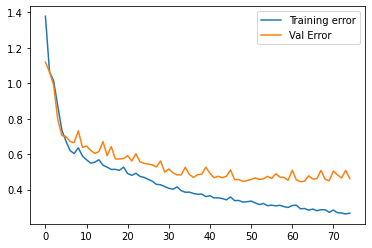

In [ ]:
# Plot the learning curve
plt.figure()
plt.plot(all_losses, label='Training error')
plt.plot(val_losses, label='Val Error')
plt.legend()

## Retrain the model on the full train dataset

In [ ]:
params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': 0}

commonlit_dataset3 = CommonLitDataset(enc_full_training_X, full_training_Y, full_training_lengths)
full_training_generator = torch.utils.data.DataLoader(commonlit_dataset3, **params)

final_model = LSTM(hidden_dim).to(device)

epochs = best_val_epoch

criterion = nn.MSELoss()

all_losses = []

start = time.time()

parameters = filter(lambda p: p.requires_grad, final_model.parameters())
optimizer = torch.optim.Adam(parameters, lr=lr)

for iter in range(1, epochs + 1):
    total = 0
    current_loss = 0.0
    final_model.train()
    for (x, seq_len), y in training_generator: # TODO: Change in full_training_generator (to include the test data)
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = final_model(x, seq_len)

        loss = criterion(y_pred, y.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*y.shape[0]
        total += y.shape[0]

    # Mean squared error
    current_loss /= total

    # Print iter number, loss
    if iter % print_every == 0:
        print('Iteration %d | %d%% (%s) MSE = %.4f' % (iter, iter / epochs * 100, timeSince(start), current_loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

Iteration 1 | 1% (0m 11s) MSE = 1.4522
Iteration 2 | 3% (0m 23s) MSE = 1.0672
Iteration 3 | 4% (0m 35s) MSE = 1.0032
Iteration 4 | 6% (0m 46s) MSE = 0.8537
Iteration 5 | 7% (0m 58s) MSE = 0.7312
Iteration 6 | 9% (1m 10s) MSE = 0.6586
Iteration 7 | 11% (1m 21s) MSE = 0.6392
Iteration 8 | 12% (1m 33s) MSE = 0.5978
Iteration 9 | 14% (1m 45s) MSE = 0.5945
Iteration 10 | 15% (1m 56s) MSE = 0.5770
Iteration 11 | 17% (2m 8s) MSE = 0.5639
Iteration 12 | 19% (2m 20s) MSE = 0.5795
Iteration 13 | 20% (2m 31s) MSE = 0.5458
Iteration 14 | 22% (2m 43s) MSE = 0.5321
Iteration 15 | 23% (2m 55s) MSE = 0.5415
Iteration 16 | 25% (3m 6s) MSE = 0.5174
Iteration 17 | 26% (3m 18s) MSE = 0.5259
Iteration 18 | 28% (3m 30s) MSE = 0.5022
Iteration 19 | 30% (3m 41s) MSE = 0.5068
Iteration 20 | 31% (3m 53s) MSE = 0.5005
Iteration 21 | 33% (4m 5s) MSE = 0.4804
Iteration 22 | 34% (4m 17s) MSE = 0.4677
Iteration 23 | 36% (4m 28s) MSE = 0.4690
Iteration 24 | 38% (4m 40s) MSE = 0.4657
Iteration 25 | 39% (4m 52s) MSE = 

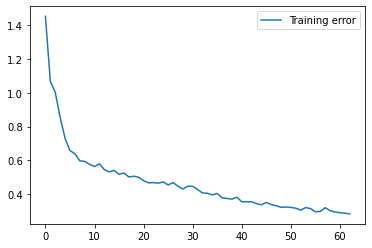

In [ ]:
# Plot the learning curve
plt.figure()
plt.plot(all_losses, label='Training error')
plt.legend()

## Evaluate the model

In [ ]:
test_params = {'batch_size': 64,
          'shuffle': False,
          'num_workers': 0}

internal_test_dataset = CommonLitDataset(enc_test_X, test_Y, test_lengths)
test_generator = torch.utils.data.DataLoader(internal_test_dataset, **test_params)


blind_test_params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 0}

blind_test_dataset = CommonLitDataset(enc_blind_test_X, np.zeros(enc_blind_test_X.shape), blind_test_lengths)
blind_test_generator = torch.utils.data.DataLoader(blind_test_dataset, **blind_test_params)

In [ ]:
# Compute the final MSE on the training set
def compute_squared_error(generator):
    error = nn.MSELoss(reduction='sum')
    with torch.no_grad():
        mse = 0.0
        for (x, seq_len), targets_batch in generator:
            x, targets_batch = x.to(device), targets_batch.to(device)

            batch_size = x.shape[0]

            output = final_model(x, seq_len)

            targets_batch = torch.reshape(targets_batch, (batch_size, 1))

            loss = error(output, targets_batch)
            mse += loss.item()
    return mse
print('Training RMSE =', np.sqrt(compute_squared_error(training_generator) / enc_training_X.shape[0]))
# A bit useless since we train also on this data
print('Internal TEST RMSE =', np.sqrt(compute_squared_error(test_generator) / enc_test_X.shape[0]))
    

Training RMSE = 0.4731130152208761
Internal TEST RMSE = 0.6675207319861894


# Compute blind test set outputs

In [ ]:
outputs = []
with torch.no_grad():
    for i, ((x, seq_len), targets_batch) in enumerate(blind_test_generator):
        excerpts_batch = x.to(device)

        batch_size = excerpts_batch.shape[0]

        output = final_model(excerpts_batch, seq_len)
        id = blind_test[i, 0]
        print(id, output.item())
        outputs.append((id, output.item()))

# Save outputs to submission.csv
if False:
    with open('submission.csv', 'w') as f:
        f.write('id,target\n')
        for id, o in outputs:
            f.write(id+','+o+'\n')

c0f722661 -1.0180059671401978
f0953f0a5 -1.0058928728103638
0df072751 -0.4917626976966858
04caf4e0c -1.1692789793014526
0e63f8bea -0.9193040728569031
12537fe78 -0.35978007316589355
965e592c0 -0.24307191371917725


 NEXT:

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
 
 
 
    Try the nn.LSTM and nn.GRU layers
    Combine multiple of these RNNs as a higher level network
